# Libraries

In [72]:
import os
import datetime
from math import sqrt
import itertools

# visualisation
import numpy as np
import pandas as pd
import missingno as mno
from scipy import signal
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['figure.figsize'] = (16,8)
plt.style.use('fivethirtyeight')
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Meta-data 

- ``global_active_power``: The total active power consumed by the household (kilowatts).
- ``global_reactive_power``: The total reactive power consumed by the household (kilowatts).
- ``voltage``: Average voltage (volts).
- ``global_intensity``: Average current intensity (amps).
- ``sub_metering_1``: Active energy for kitchen (watt-hours of active energy).
- ``sub_metering_2``: Active energy for laundry (watt-hours of active energy).
- ``sub_metering_3``: Active energy for climate control systems (watt-hours of active energy)

In general terms, the <b>active energy</b> is the real power consumed by the household, whereas the reactive energy is the unused power in the lines.

# Data fetching

**Stop and think**   
We should not forget to specify some parameters to ensure the data is loaded correctly:

- Specify the separate between columns as a semicolon (sep=’;’)
- Specify that line 0 has the names for the columns (header=0)
- Specify that we have lots of RAM to avoid a warning that we are loading the data as an array of objects instead of an array of numbers, because of the ‘?’ values for missing data (low_memory=False).
- Specify that it is okay for Pandas to try to infer the date-time format when parsing dates, which is way faster (infer_datetime_format=True)
- Specify that we would like to parse the date and time columns together as a new column called ‘datetime’ (parse_dates={‘datetime’:[0,1]})
- Specify that we would like our new ‘datetime’ column to be the index for the DataFrame (index_col=[‘datetime’]).

In [6]:
# define dataset path
datapath="../data/raw/household_unique/household_power_consumption.txt"

In [47]:
# import / read dateset file
ts_house = pd.read_csv(datapath, sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

# Data scrubbing

In [17]:
# dataset overview
ts_house.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [10]:
# dataset summary
ts_house.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


**Stop and think**     
We need to convert all features instances into float64 before going further through scrubbing, and replace '?' missing values into 'NaNs value as well.

In [48]:
# missing value marking
ts_house.replace('?', np.NaN, inplace=True)

In [49]:
# marking check
ts_house.values[ts_house.values == '?'].sum()

0

In [50]:
# dataset parsing from object into float64
ts_house = ts_house.astype(np.float64)

In [51]:
# parsing check 
ts_house.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


## Missing values

In [59]:
# missing values check
ts_house.isnull().value_counts()

Global_active_power  Global_reactive_power  Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3
False                False                  False    False             False           False           False             2049280
True                 True                   True     True              True            True            True                25979
dtype: int64

<AxesSubplot:ylabel='datetime'>

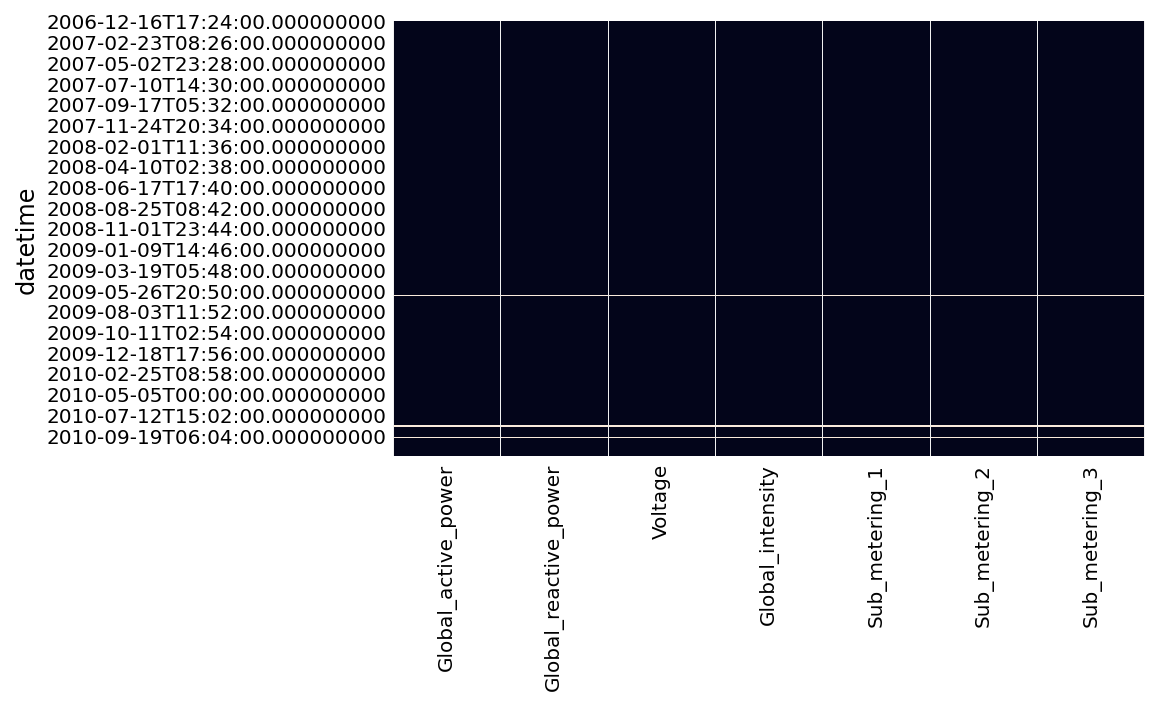

In [74]:
# missing values heatmap
sns.heatmap(ts_house.isnull(), cbar=False)

## Duplicates

In [70]:
# dataset duplicates ratio check
ts_house.duplicated().value_counts()

False    1906699
True      168560
dtype: int64

**Summary**     
- Converted object features into float64
- Replaced '?' into NaNs
- Sub_metering_3 25979 missing values
- 168560 duplicates 

In [ ]:
# save updated dataset
ts_house.to_csv('../data/interim/household_unique/household_power_consumption.csv')

# Exploratory data analysis

## 